# Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Model
from keras.layers import Input,  Dense, LSTM, GRU, Concatenate, Add
from keras.layers import Embedding

from keras.optimizers import RMSprop

from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard


from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
from PIL import Image

In [4]:
vocab_size=10000

In [5]:
word2vec_dim=300

In [6]:
rnn_output_dim = 512

In [7]:
num_merge_layers=2

In [8]:
decoder_output_dim = vocab_size 

In [1]:
distractor_start = 'ssss '
distractor_end = ' eeee'

# Encoder

In [9]:
def connect_encoder(suffix=""):
    # Start the neural network with its input-layer.
    encoder_input = Input(shape=(None, ), name='encoder_input_' + suffix)
    
    # Connect the embedding-layer.
    encoder_embeddings = Embedding(input_dim=vocab_size, output_dim=word2vec_dim, name='encoder_embedding_' + suffix)(encoder_input)

    # Connect all the GRU-layers.
    encoder_layer_1 = GRU(rnn_output_dim, name='encoder_layer_1_' + suffix, return_sequences=True)(encoder_embeddings)
    encoder_layer_2 = GRU(rnn_output_dim, name='encoder_layer_2_' + suffix, return_sequences=True)(encoder_layer_1)

    # This is the output of the encoder.
    encoder_output = GRU(rnn_output_dim, name='encoder_output_' + suffix, return_sequences=False)(encoder_layer_2)
    
    return encoder_input, encoder_output

In [10]:
encoder_input_question, encoder_output_question = connect_encoder(suffix="question")

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
encoder_input_answer, encoder_output_answer = connect_encoder(suffix="answer")

In [12]:
encoder_output = Concatenate()([encoder_output_question, encoder_output_answer])

In [13]:
model_encoder = Model(inputs=[encoder_input_question,encoder_input_answer], outputs=[encoder_output])

In [14]:
plot_model(model_encoder,show_shapes=True, to_file='model_encoder.png')

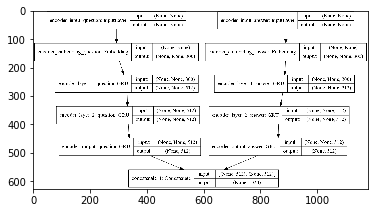

In [15]:
image = Image.open('model_encoder.png')
plt.imshow(image)

# Decoder

In [16]:
decoder_initial_state = Input(shape=(rnn_output_dim*num_merge_layers,), name='decoder_initial_state')

In [17]:
def connect_decoder(initial_state, suffix=""):
    # Start the decoder-network with its input-layer.
    decoder_input = Input(shape=(None, ), name='decoder_input_' + suffix)

    # Connect the embedding-layer.
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=word2vec_dim,  name='decoder_embedding_'+suffix)(decoder_input)
    
    # Connect all the GRU-layers.
    decoder_layer_1 = GRU(rnn_output_dim*num_merge_layers, name='decoder_layer_1_' + suffix, return_sequences=True)(decoder_embedding, initial_state=initial_state)
    decoder_layer_2 = GRU(rnn_output_dim*num_merge_layers, name='decoder_layer_2_' + suffix, return_sequences=True)(decoder_layer_1, initial_state=initial_state)
    decoder_layer_3 = GRU(rnn_output_dim*num_merge_layers, name='decoder_layer_3_' + suffix, return_sequences=True)(decoder_layer_2, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = Dense(decoder_output_dim, activation='linear', name='decoder_output_'+suffix)(decoder_layer_3)
    
    return decoder_input, decoder_output

In [18]:
decoder_input, decoder_output = connect_decoder(decoder_initial_state)

In [19]:
model_decoder = Model(inputs=[decoder_input, decoder_initial_state], outputs=[decoder_output])

In [20]:
plot_model(model_decoder, show_shapes=True, to_file='model_decoder.png')

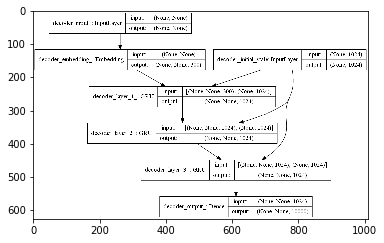

In [21]:
image = Image.open('model_decoder.png')
plt.imshow(image)

# Model Input and Output

In [26]:
decoder_input_distractor_1, decoder_output_distractor_1 = connect_decoder(encoder_output,"distractor_1")

In [27]:
decoder_input_distractor_2, decoder_output_distractor_2 = connect_decoder(encoder_output,"distractor_2")

In [28]:
decoder_input_distractor_3, decoder_output_distractor_3 = connect_decoder(encoder_output,"distractor_3")

In [29]:
model_train = Model(
    inputs = [encoder_input_question, encoder_input_answer, 
              decoder_input_distractor_1, decoder_input_distractor_2, decoder_input_distractor_3], 
    outputs = [decoder_output_distractor_1,decoder_output_distractor_2, decoder_output_distractor_3]
)

In [30]:
plot_model(model_train, show_shapes=True, to_file='model_train.png')

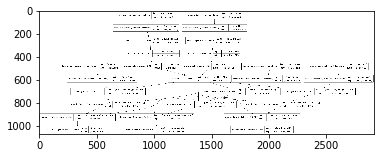

In [31]:
image = Image.open('model_train.png')
plt.imshow(image)

# Cost Function

In [32]:
model_train.compile(optimizer=RMSprop(lr=1e-3),
              loss={
                  'decoder_output_distractor_1': 'sparse_categorical_crossentropy', 
                  'decoder_output_distractor_2': 'sparse_categorical_crossentropy', 
                  'decoder_output_distractor_3': 'sparse_categorical_crossentropy' 
              })


# Checkpoints


In [33]:
callback_checkpoint = ModelCheckpoint(filepath="checkpoint", monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)

In [34]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [35]:
callback_tensorboard = TensorBoard(log_dir='./logs/', histogram_freq=0, write_graph=False)

In [36]:
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard]

# Training

In [37]:
model_train.fit(x=\
          {
              'encoder_input_question': None, 
              'encoder_input_answer': None,
              'decoder_input_distractor_1': None,
              'decoder_input_distractor_2': None,
              'decoder_input_distractor_3': None,
          },
          y=\
          {
               'decoder_output_distractor_1': None, 
               'decoder_output_distractor_2': None, 
               'decoder_output_distractor_3': None 
          },
          batch_size=32, 
          epochs=50,
          validation_split=0.2,
          callbacks=callbacks)

AttributeError: 'NoneType' object has no attribute 'shape'